# Find signature areas with and without missing signatures with Keras, Tesseract, and ImageMagick

We want to find contract pages that have signature areas with missing signatures. Our strategy is to use Tesseract to search for typical words such as "som kjøper" and "som selger" that usually appear near a signature field, extract a "signature area" image around these words, and classify them as "containing a signature" or "not containing a signature".

In [5]:
import os, glob
import numpy as np
import random
from PIL import Image, ImageDraw, ImageFont
from bs4 import BeautifulSoup as soup
import re
import matplotlib.pyplot as plt

We'll develop our approach using this example contract from EiendomsMegler 1: ![](samples/eiendomsmegler1_kontrakt.png)

We start by writing a helper function that will generate a text file with bounding boxes from the image we want to detect signatures in:

In [6]:
def hocr_pdf(pdf_file_name,temp_file_name = "temp_pdf_png"):
    os.system("rm {0}*".format(temp_file_name))
    os.system("convert -density 300 -depth 8 -quality 85 {0} temp_pdf_png.png".format(pdf_file_name))
    png_files = glob.glob("{0}*.png".format(temp_file_name))
    
    for png_file in png_files:
        file = png_file.replace(".png","")
        os.system("tesseract -l nor {0} {1} hocr".format(png_file, file))

    if os.path.isfile("{0}.png".format(temp_file_name)):
        os.system("mv {0}.png {0}-0.png".format(temp_file_name))
        os.system("mv {0}.hocr {0}-0.hocr".format(temp_file_name))
    
    hocr_files = sorted(glob.glob("{0}*.hocr".format(temp_file_name)))
    
    return(hocr_files)

We use beautifulsoup to find the elements containing the keywords we want to trigger signature detection in. By default we use "Som kjøper", "Som selger", "For kjøper", "For selger", "Kjøpers underskrift", "Selgers underskrift":

In [90]:
def search_hocr_for_sentence(sentence, trigger_dict, hocr, page_num):
    
    word_span_list = hocr.find_all("span", {"id" : lambda L: L and L.startswith('word_')})
    
    word_list = []
    word_id_list = []
    bbox_list = []
    
    for word_span in word_span_list:
        word = re.sub(r'[^\w\s]','',word_span.find(text=True))
        word_id = int(word_span["id"].replace("word_1_",""))
        bbox = word_span["title"].replace(";","").split()[1:5]
        
        word_list.append(word)
        word_id_list.append(word_id)
        bbox_list.append(bbox)
    
    sentence_words = sentence.split()
    sentence_length=len(sentence_words)
    
    n=0
    for i in range(len(word_list)):
        if word_list[i] == sentence_words[0]:
            candidate_sentence = " ".join(word_list[i:(i+sentence_length)])
            if candidate_sentence == sentence:
                n+=1
                bbox = bbox_list[i+sentence_length-1]
                trigger_dict.update({sentence+" "+str(n) : {"page" : page_num,
                                                            "x0":int(bbox[0]),
                                                            "y0":int(bbox[1]),
                                                            "x1":int(bbox[2]),
                                                            "y1":int(bbox[3])}})
    return(trigger_dict, word_list, word_id_list, bbox_list)


def get_trigger_areas(hocr_list,
                      trigger_sentences = ["For kjøper",
                                           "For selger",
                                           "Kjøpers underskrift",
                                           "Selgers underskrift",
                                           "Som kjøper",
                                           "Som selger"]):
    trigger_dict = {}
    
    page_num=0
    for hocr_file in hocr_list:
        page_num+=1
        with open(hocr_file,"r") as file:
            hocr = soup(file, "html5lib")
        
        for trigger_sentence in trigger_sentences:
            trigger_dict, word_list, word_id_list, bbox_list = search_hocr_for_sentence(trigger_sentence,
                                                                                        trigger_dict,
                                                                                        hocr,
                                                                                        page_num)
    return(trigger_dict, word_list, word_id_list, bbox_list)


In [91]:
trigger_dict,_,_,_ = get_trigger_areas(hocr_pdf("samples/eiendomsmegler1_kontrakt.png"))

In [25]:
trigger_dict

{'Som kjøper 1': {'page': 1, 'x0': 749, 'y0': 880, 'x1': 824, 'y1': 905},
 'Som selger 1': {'page': 1, 'x0': 179, 'y0': 880, 'x1': 249, 'y1': 905}}

Let's extract images of each detected signature field. We'll use the font size (from the height of the bounding box) to scale the extracted area: The larger the font, the larger the extracted image:

In [26]:
def extract_signatures(trigger_dict, 
                       rel_left=3,
                       rel_right=15,
                       rel_up=0,
                       rel_down=6,
                       temp_file_name="temp_pdf_png"):
    sig_img_list = []
    for trigger in trigger_dict:
        page_file  = temp_file_name + "-" + str(trigger_dict[trigger]["page"]-1) + ".png"
        page_img   = Image.open(page_file)
        page_width = page_img.size[0]
        page_height= page_img.size[1]
        
        x0 = trigger_dict[trigger]["x0"]
        x1 = trigger_dict[trigger]["x1"]
        y0 = trigger_dict[trigger]["y0"]
        y1 = trigger_dict[trigger]["y1"]
        
        font_height = y1-y0
        
        x0 = np.max([x0 - font_height*rel_left, 0])
        x1 = np.min([x0 + font_height*rel_right, page_width])
        y0 = np.max([y0 - font_height*rel_up, 0])
        y1 = np.min([y0 + font_height*rel_down, page_height])
        
        crop_img = page_img.crop((x0,y0,x1,y1))
        sig_img_list.append(crop_img)
    
    return(sig_img_list)

In [ ]:
img_list = extract_signatures(trigger_dict)

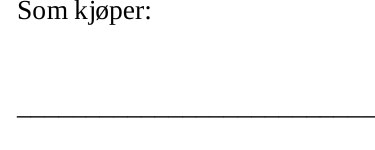

In [35]:
img_list[0]

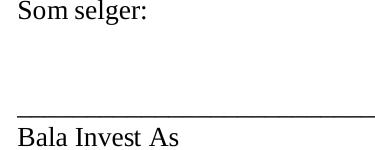

In [36]:
img_list[1]

This works pretty well! Our next step is to build a training data set for the neural net that will decide if each image contains a signature. We'll generate a bunch of signature areas of various sizes, with and without signatures:

In [70]:
def generate_signature(width, height, filename):
    
    img = Image.open(filename)
    new_width  = width
    new_height = height
    img = img.resize((new_width, new_height), Image.ANTIALIAS)
    
    return(img)


def signature_box_content(width, height, text, signed=True, horizontal_line = True, sig_directory="signatures", font="DejaVuSerif.ttf"):
    
    bottom_margin = np.int(np.max([np.round(height*0.15),1]))
    
    sig_img = Image.new("RGB", (width,height), color="white")
    
    draw = ImageDraw.Draw(sig_img)
    
    if horizontal_line:
        draw.line((0, sig_img.size[1]-bottom_margin, sig_img.size[0], sig_img.size[1]-bottom_margin), fill="black")
    
    fnt_size = bottom_margin
    txt_fnt = ImageFont.truetype(font, fnt_size)
    draw.text((0,0), text, font=txt_fnt, fill="black")
    
    if signed:
        sig_width = np.random.randint(low=np.round(width/3),high=width)
        sig_left_margin = np.random.randint(width-sig_width)
        sig_filename = random.choice(os.listdir(sig_directory))
        #print(sig_filename) Uncomment to debug signature.png-s with bad transparency masks
        signature = generate_signature(sig_width, height-bottom_margin, sig_directory+"/"+sig_filename)
        sig_img.paste(signature, (sig_left_margin,bottom_margin), signature)
        
    return(sig_img, bottom_margin)

In [72]:
def generate_signatures(N,
                        trigger_sentences = ["Som kjøper:",
                                           "Som selger:",
                                           "For kjøper:",
                                           "For selger:",
                                           "Kjøpers underskrift:",
                                           "Selgers underskrift:"],
                        pct_validate=0.1,
                        path="signature_output",
                        signed_probability=0.5,
                        horizontal_line_probability=0.5,
                        signature_width_min = 200,
                        signature_width_max = 600,
                        signature_height_min= 100,
                        signature_height_max= 400,
                        font = "DejaVuSerif.ttf", # TODO: Randomly sample fonts from folder
                        font_size_min = 20,
                        font_size_max = 50):

    N_length = len(str(N))
    
    os.system("rm -R {0}".format(path))
    os.system("mkdir {0}".format(path))
    os.system("mkdir {0}/train".format(path))
    os.system("mkdir {0}/train/signed".format(path))
    os.system("mkdir {0}/train/not_signed".format(path))
    os.system("mkdir {0}/validation".format(path))
    os.system("mkdir {0}/validation/signed".format(path))
    os.system("mkdir {0}/validation/not_signed".format(path))
    
    for n in range(0,(N)):
        
        height = np.random.randint(low=signature_height_min, high=signature_height_max)
        width = np.int(np.min([height*1.6,np.random.randint(low=signature_width_min, high=signature_width_max)]))
        
        box_is_signed = np.random.rand()<signed_probability
        box_has_line = np.random.rand()<horizontal_line_probability
        
        sign_box_text = random.choice(trigger_sentences)
            
        sig_img, _ = signature_box_content(width, height, sign_box_text, box_is_signed, box_has_line)
        
        #n_string = str(n+1).zfill(N_length)
        n_string = str(n+1)
        
        N_train = np.int(N*(1-pct_validate))

        if n<N_train:
            if box_is_signed:
                   sig_img.save(path+"/train/signed/"+n_string+".png")
            else:
                   sig_img.save(path+"/train/not_signed/"+n_string+".png")
        else:
            if box_is_signed:
                   sig_img.save(path+"/validation/signed/"+n_string+".png")
            else:
                   sig_img.save(path+"/validation/not_signed/"+n_string+".png")
        
        if (n+1) % 1000 == 0:
            print(str(n+1) + " of " +str(N))
            
    return("Done! Synthetic signatures written to "+path)

In [74]:
generate_signatures(2000)

1000 of 2000
2000 of 2000


'Done! Synthetic signatures written to signature_output'

Now let's see if we can teach a small CNN to tell the difference between signed signature areas and signature areas with missing signatures (see https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html for details):

In [75]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'signature_output/train'
validation_data_dir = 'signature_output/validation'
nb_train_samples = 1800
nb_validation_samples = 200
epochs = 10
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

#model.save_weights('first_try.h5')
model.save('model.h5')

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/10
112/112 [==============================] - 33s 290ms/step - loss: 0.4505 - acc: 0.8683 - val_loss: 0.0135 - val_acc: 0.9896
Epoch 2/10
112/112 [==============================] - 32s 288ms/step - loss: 0.4263 - acc: 0.9531 - val_loss: 0.0129 - val_acc: 0.9948
Epoch 3/10
112/112 [==============================] - 32s 288ms/step - loss: 0.1121 - acc: 0.9844 - val_loss: 1.1909e-07 - val_acc: 1.0000
Epoch 4/10
112/112 [==============================] - 32s 287ms/step - loss: 0.3288 - acc: 0.9749 - val_loss: 1.2344e-07 - val_acc: 1.0000
Epoch 5/10
112/112 [==============================] - 32s 288ms/step - loss: 0.0824 - acc: 0.9894 - val_loss: 0.0952 - val_acc: 0.9844
Epoch 6/10
112/112 [==============================] - 32s 288ms/step - loss: 0.0804 - acc: 0.9905 - val_loss: 1.3874e-06 - val_acc: 1.0000
Epoch 7/10
112/112 [==============================] - 33s 290ms/step - loss: 0.0316 - acc: 0.99

The model validates well on the synthetic signatures, but what about real cases not based on synthetic data? Let's give it a go on the contract example from Eiendomsmegler 1:

In [76]:
from keras.models import load_model
from keras.preprocessing import image

def predict_image(model_name, img, threshold=0.5, show=False):

    img = img.convert('RGB')
    
    img = img.resize((150, 150), Image.ANTIALIAS)
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()
    
    model = load_model(model_name)
    
    pred = model.predict(img_tensor)
    
    if pred[0]<threshold:
        conclusion = False # "Not signed!"
        confidence = (threshold-pred)/threshold
    else:
        conclusion = True # "Signed!"
        confidence = (pred-threshold)/(1-threshold)
    
    return conclusion, np.round(confidence,4)

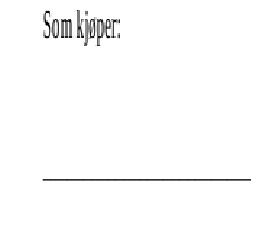

(False, array([[0.9987]], dtype=float32))

In [77]:
predict_image("model.h5",img_list[0],show=True)

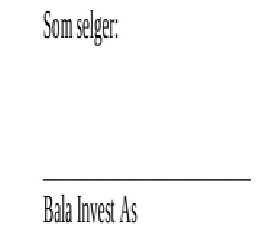

(False, array([[1.]], dtype=float32))

In [78]:
predict_image("model.h5",img_list[1],show=True)

"False" means "Not signed" in this contect, and 1. means the model is pretty damn confident about its' conclusion. Looking good! Now what if we sign this contract by hand, with a signature not earlier seen by the model during training?
![](samples/eiendomsmegler1_kontrakt_signed.png)

In [79]:
signed_trigger_dict,_,_,_ = get_trigger_areas(hocr_pdf("samples/eiendomsmegler1_kontrakt_signed.png"))
signed_img_list = extract_signatures(signed_trigger_dict)

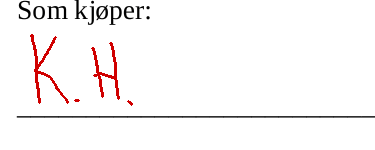

In [80]:
signed_img_list[0]

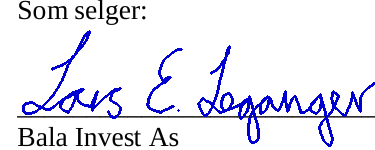

In [81]:
signed_img_list[1]

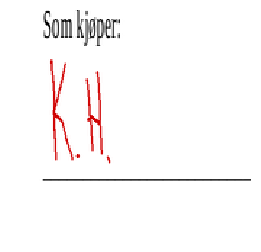

(True, array([[1.]], dtype=float32))

In [82]:
predict_image("model.h5",signed_img_list[0],show=True)

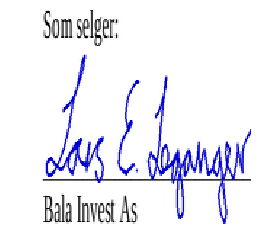

(True, array([[1.]], dtype=float32))

In [83]:
predict_image("model.h5",signed_img_list[1],show=True)

Well done, AI-signature-detector!

Let's create some functions to gather all of the above toghether:

In [85]:
def score_signatures(trigger_dict, 
                     rel_left=3,
                     rel_right=15,
                     rel_up=0,
                     rel_down=6,
                     model="model.h5",
                     temp_file_name="temp_pdf_png"):
    
    for trigger in trigger_dict:
        page_file  = temp_file_name + "-" + str(trigger_dict[trigger]["page"]-1) + ".png"
        page_img   = Image.open(page_file)
        page_width = page_img.size[0]
        page_height= page_img.size[1]
        
        x0 = trigger_dict[trigger]["x0"]
        x1 = trigger_dict[trigger]["x1"]
        y0 = trigger_dict[trigger]["y0"]
        y1 = trigger_dict[trigger]["y1"]
        
        font_height = y1-y0
        
        x0 = np.max([x0 - font_height*rel_left, 0])
        x1 = np.min([x0 + font_height*rel_right, page_width])
        y0 = np.max([y0 - font_height*rel_up, 0])
        y1 = np.min([y0 + font_height*rel_down, page_height])
        
        crop_img = page_img.crop((x0,y0,x1,y1))
        
        signed, confidence = predict_image(model,crop_img,show=False)
        
        trigger_dict[trigger].update({"x0":int(x0),
                                      "x1":int(x1),
                                      "y0":int(y0),
                                      "y1":int(y1),
                                      "signed":signed, 
                                      "confidence":np.float(confidence)})
    
    return(trigger_dict)

In [86]:
def score_pdf(pdf_file_name):
    hocr_files = hocr_pdf(pdf_file_name)
    trigger_dict,_,_,_ = get_trigger_areas(hocr_files)
    score_dict = score_signatures(trigger_dict)
    
    return(score_dict)

Let's try our scoring function on Forbrukerrådet's recommended contract. We expect the (unsigned) signatures to be on page 5:

In [92]:
score_pdf("samples/forbrukerrådet_kontrakt.pdf")

{'Kjøpers underskrift 1': {'page': 5,
  'x0': 184,
  'y0': 2595,
  'x1': 514,
  'y1': 2727,
  'signed': False,
  'confidence': 0.9998000264167786},
 'Selgers underskrift 1': {'page': 5,
  'x0': 183,
  'y0': 2703,
  'x1': 513,
  'y1': 2835,
  'signed': False,
  'confidence': 1.0}}

And what about a contract for buying a used car?

In [93]:
score_pdf("samples/bil_kontrakt.pdf")

{'Kjøpers underskrift 1': {'page': 1,
  'x0': 1675,
  'y0': 3333,
  'x1': 2080,
  'y1': 3495,
  'signed': False,
  'confidence': 1.0},
 'Selgers underskrift 1': {'page': 1,
  'x0': 890,
  'y0': 3333,
  'x1': 1295,
  'y1': 3495,
  'signed': False,
  'confidence': 1.0}}

This is really all we need! But... wouldn't it be cool to also return the PDF with the signature detections marked? Yeah, let's give it a try:

In [95]:
import img2pdf

def visualize_detections(trigger_dict, out_filename, fnt_size=30, temp_file_name = "temp_pdf_png"):
    
    png_file_dict = {}
    for trigger in trigger_dict:
        
        page_file  = temp_file_name + "-" + str(trigger_dict[trigger]["page"]-1) + ".png"
        img = Image.open(page_file).convert("RGB")
        drawing = ImageDraw.Draw(img)
        
        top_left = (trigger_dict[trigger]["x0"],trigger_dict[trigger]["y0"])
        bottom_right= (trigger_dict[trigger]["x1"],trigger_dict[trigger]["y1"])

        text_start_x = trigger_dict[trigger]["x0"]
        text_start_y = trigger_dict[trigger]["y1"]-fnt_size
        text_start = (text_start_x, text_start_y)
        
        txt_fnt  = ImageFont.truetype("DejaVuSerif.ttf", fnt_size)

        if trigger_dict[trigger]["signed"]==True:
            color="green"
            text = str(trigger)+" Signed! Conf.: " + str(trigger_dict[trigger]["confidence"])
        else:
            color="red"
            text = str(trigger)+" Not signed! Conf.: " + str(trigger_dict[trigger]["confidence"])

        drawing.rectangle([top_left, bottom_right], outline=color)
        drawing.text(text_start, text, font=txt_fnt, fill=color)
        
        img.save(page_file)
        
        img_list = sorted(glob.glob("{0}*.png".format(temp_file_name)))
        with open(out_filename, "wb") as f:
            f.write(img2pdf.convert(img_list))
            
    return("Done! Visualized detections written to " + out_filename)

In [99]:
bil_dict = score_pdf("samples/bil_kontrakt.pdf")
visualize_detections(bil_dict, "samples/bil_viz.pdf")

'Done! Visualized detections written to samples/bil_viz.pdf'

Go ahead and have a look :)